# Automatic cube solver

Opencv project. The program recognizes the pictures of each side of a Rubik's cube and recommends a solution based on Kociemba's 2 phase algorithm

The inputs are pictures of the 6 faces of a 3X3 Rubik's cube. The program recognizes the individual squares (a.k.a cubies) on the cube faces, determines their order, then recommends a solution based on Kociemba's 2 phase algorithm.

Author: Roland Kövecs (GPZN1J)

In [98]:
import time
import os
import mediapipe as mp
import matplotlib.pyplot as plt
from skimage import measure
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import sklearn.cluster
import itertools
import statistics
import cv2
import scipy
import plotly.graph_objs as go
import colorsys
import kociemba

Populating the interactive namespace from numpy and matplotlib


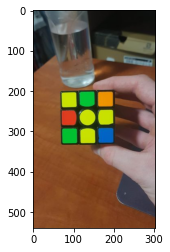

(540, 304, 3)


In [99]:
path = "cub1.jpg"

orig_img = cv2.imread(path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
#plt.imshow(img)
plt.show()
print(np.shape(img))



### Recognizing the cubies

I have to recognize multiple, unknown shaded colors, so color filtering is not really an option here.
The K value needed some experimantation, since it is important to find all necessary clusters, but not too many of them. We mainly aim at the small squares on the faces of the cube, a.k.a. "cubies". For the clustering, the regular RGB worked well.

In [100]:
K = 6
rgb = img.reshape((-1,3))
kmeans = sklearn.cluster.KMeans(n_clusters=K).fit(rgb)

kmeans = sklearn.cluster.KMeans(n_clusters=K,init=kmeans.cluster_centers_,n_init=1).fit(rgb)
#print(np.shape(img))
pred = kmeans.predict(rgb)
res = pred.reshape((np.shape(img)[0],np.shape(img)[1]))
np.shape(res)
regions = measure.label(res,connectivity=1,background=-10)
props = measure.regionprops(regions)

The clustering happens here. The program calculates the median area of the specified cubies, in case if a similar shaped object fitted the area and aspect ratio requirements. We use the median area later to sort out the "fake" cubies. The meanarea naming is just for the sake of abbrevation, must not be confused.

meanarea 1274.0 meanside 35
areas [550, 1290, 1260, 1291, 1156, 1255, 1304, 1288, 1312, 1256]
#regions:  10


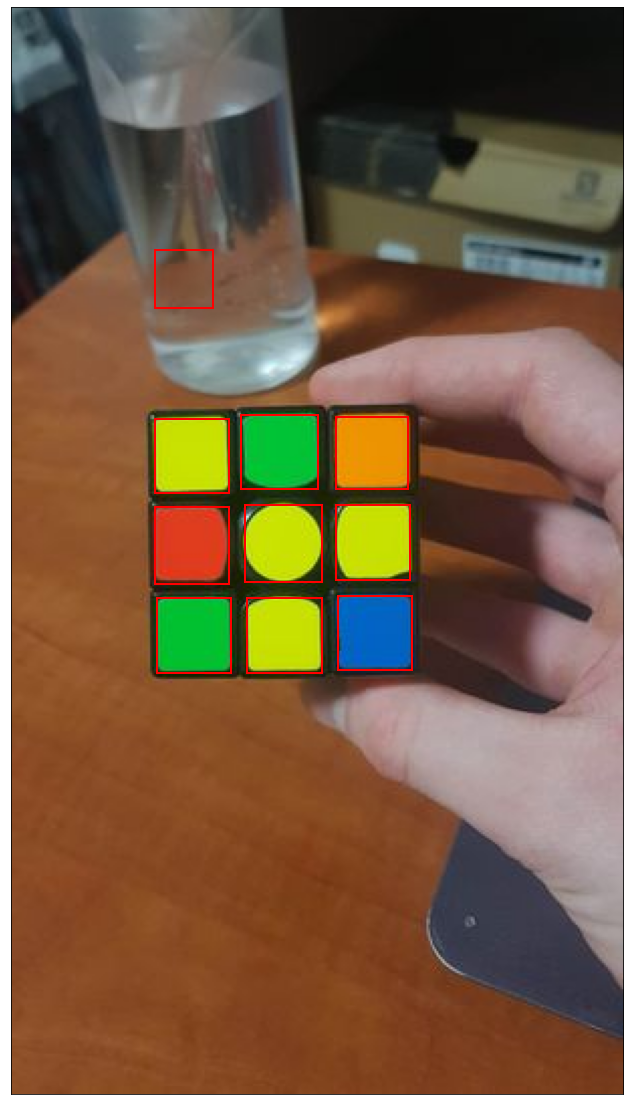

In [101]:
regcount = 0
aspects = []
areas = []
cut_cubies = []


fig, (ax1) = plt.subplots(1,figsize=(20,20))
plt.xticks([]),plt.yticks([])
ax1.imshow(img)
for region in measure.regionprops(regions):
    if region.area < 500 or region.area > res.shape[0]*res.shape[1]*0.05 :
        continue
    minRow, minCol, maxRow, maxCol = region.bbox
    aspect = (maxCol-minCol) / (maxRow-minRow)
    if aspect > 1.1 or aspect < 0.9:
        continue
    areas.append(region.area)
    
    minRow, minCol, maxRow, maxCol = region.bbox
    rectBorder = matplotlib.patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
    cut_cubies.append([minRow, minCol, maxRow, maxCol])
    ax1.add_patch(rectBorder)
    regcount += 1
    ##print(abs(region.area-meanarea))

meanarea = np.median(areas)
meanside = int(np.sqrt(meanarea))
print("meanarea", meanarea, "meanside", meanside)
print("areas",areas)
print("#regions: ", regcount)
plt.show()

Defining the clustering function for later use

In [102]:
def clustering(img):
    K= 6
    aspects = [] #aspect ratios
    areas = [] 
    cut_cubies = [] #the clusters with proper area and aspect ratio

    rgb = img.reshape((-1,3))
    kmeans = sklearn.cluster.KMeans(n_clusters=K).fit(rgb)
    kmeans = sklearn.cluster.KMeans(n_clusters=K,init=kmeans.cluster_centers_,n_init=1).fit(rgb)
    #print(np.shape(img))
    pred = kmeans.predict(rgb)
    res = pred.reshape((np.shape(img)[0],np.shape(img)[1]))
    np.shape(res)
    regions = measure.label(res,connectivity=1,background=-10)


    for region in measure.regionprops(regions):
        if region.area < 500 or region.area > res.shape[0]*res.shape[1]*0.05 :
            continue
        minRow, minCol, maxRow, maxCol = region.bbox
        aspect = (maxCol-minCol) / (maxRow-minRow)
        if aspect > 1.1 or aspect < 0.9:
            continue
        areas.append(region.area)
        
        minRow, minCol, maxRow, maxCol = region.bbox
        cut_cubies.append([minRow, minCol, maxRow, maxCol])

    meanarea = np.median(areas)

    
    return cut_cubies, meanarea

cut_cubies, meanarea = clustering(img)
meanside = int(np.sqrt(meanarea))
print(np.shape(cut_cubies))

(10, 4)


Here we still have 1 more cubie but we will sort this out later with the help of meanside

### The order of the colors

In the following, we have to determine the color of each cubie. In order to do this properly, we should understand how the Kociemba module stores the cube's order. It is really important to pay attention to the orientation of each face when taking pictures!!

In [ ]:
"""
Cube colors for kociemba modul:

             |************|
             |*U1**U2**U3*|
             |************|
             |*U4**U5**U6*|
             |************|
             |*U7**U8**U9*|
             |************|
 ************|************|************|************
 *L1**L2**L3*|*F1**F2**F3*|*R1**R2**R3*|*B1**B2**B3*
 ************|************|************|************
 *L4**L5**L6*|*F4**F5**F6*|*R4**R5**R6*|*B4**B5**B6*
 ************|************|************|************
 *L7**L8**L9*|*F7**F8**F9*|*R7**R8**R9*|*B7**B8**B9*
 ************|************|************|************
             |************|
             |*D1**D2**D3*|
             |************|
             |*D4**D5**D6*|
             |************|
             |*D7**D8**D9*|
             |************|
             
A cube definition string "UBL..." means that in position U1 we have the U-color, in position U2 we have the B-color, in position U3 we have the L color etc. 
according to the order U1, U2, U3, U4, U5, U6, U7, U8, U9, R1, R2, R3, R4, R5, R6, R7, R8, R9, F1, F2, F3, F4, F5, F6, F7, F8, F9, D1, D2, D3, D4, D5, D6, D7, D8, D9, L1, L2, L3, L4, L5, L6, L7, L8, L9, B1, B2, B3, B4, B5, B6, B7, B8, B9.

So a solved cube looks like this: UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB

My fav position: front green, up yellow 
"""

Functions for assigning colors to cubies

In [104]:
#defining a simple euclidean distance metric on color difference source: wiki

#Saving the color codes in a dictionary, keeping in mind the order of the cube's faces's colors. The dominant colors needed some experimenting as well
colors = {
  "U": [201,221,1],
  "R": [255,140,0],
  "F": [0,255,0],
  "D": [187, 210, 216],
  "L": [255, 0, 0],
  "B": [0,0,255], 
}

#color_names = ["L", "R", "F", "B", "D", "U"] #regi 
color_names = ["U", "R", "F", "D", "L", "B"]

#defining a simple euclidean distance metric on color difference source: wiki
def color_picker(col):
    col = np.array(col,dtype=int)

    deltas = []
    for name in color_names:
      ref_col = colors[name]
      delta = np.sqrt((col[0]-ref_col[0])**2 + (col[1]-ref_col[1])**2 + (col[2]-ref_col[2])**2)
      #print("color_difi with",name , delta)
      deltas.append(delta)

    if np.min(deltas)<200:
      return list(colors)[np.argmin(deltas)]
    else:
      return 0 #if the cubie's color would not match any of the 6 dominant color of the cube.


In [105]:

#test of color picker
red_average_color = [213.89896667,  61.36161111,  33.14824444]
#red_average_color = np.array(red_average_color,dtype=int)

white_average_color = [179.33543333, 211.93733333, 207.74614444]
blue_average_color = [1.45755556, 108.36142222, 182.14407778]
white_average_color = np.array(white_average_color,dtype=int)

black = [23.1912,     35.47926667, 18.35713333]

print(white_average_color[0])
#color_picker(white_average_color)
color_picker(black)

179


0

### Locating the colors on the 3x3 cube face.

Defining the color locator function. Storing the coordinates and colors of each cubie

In [106]:
def cubie_colors(cut_cubies, meanarea, meanside, border=0):

  #cubie_coords_arr contains the coordinates 
 


  cubies = [] #chooped pic of good cubies, also contains the colors of the clustered cubies 
  cubie_coords = [] #coordinates of good cubies, top left corner of clustered cubies
  face = [] #saving cubies with colors: RGBYOW

  orig_img = plt.imread(path)

  i = 0
  for cubie in cut_cubies:
      cubiearea = (cubie[2]-cubie[0])*(cubie[3]-cubie[1])
      if cubiearea/meanarea >1.3 or cubiearea/meanarea<0.7:
        continue

      cubie_coords.append(cubie)

      if cubie[0]-border>0 and cubie[1]-border>0:

        cubie_pic1 = orig_img[(cubie[0]-border):(cubie[2]+border),(cubie[1]-border):(cubie[3]+border)] #chopped cubie pic if not at the border
        cube_color = cv2.cvtColor(cubie_pic1, cv2.COLOR_BGR2HSV)
        average_color_row = np.average(cubie_pic1, axis=0)
        average_color = np.average(average_color_row, axis=0)

        cubies.append([cv2.resize(cubie_pic1,(300,300)), color_picker(average_color)])
      else:
        cubie_pic2 = orig_img[(cubie[0]):(cubie[2]),(cubie[1]):(cubie[3])] #if cubie at border
        cube_color = cv2.cvtColor(cubie_pic2, cv2.COLOR_BGR2HSV)
        average_color_row = np.average(cubie_pic2, axis=0)
        average_color = np.average(average_color_row, axis=0)

        cubies.append([cv2.resize(cubie_pic2,(300,300)),color_picker(average_color)])

  cubie_coords_arr = np.array(cubie_coords)
  #print("coordshape_colorfun: ",np.shape(cubie_coords_arr))
  
  return cubie_coords_arr, cubies

Finding the order of the colors on the cube faces. First find center piece which has 9 neighbours, then compare each cubie's coordinates to the center one's

In [107]:

def cubie_locator(cubie_coords_arr,cubies, meanside):
    tol = meanside*0.2   #tol is the tolerance value for the mislocated rows and cols



    a=np.zeros((9,2))
    #print("type",type(cubie_coords_arr))
    #print("cubies type",type(cubies))

    a = cubie_coords_arr 
    #print(a)

    neighs = np.zeros((9,2)) #neighbours 

    face = [0 for i in range(0,9)] #save cubie colors on face here
    #face[0] = cubie[0][-1]
    
    #print(cubie[0][-1])

    #find center piece
    for i in range(9):
        neignum = 0
        for j in range(9):
            if j != i:

                if abs(a[i][0]-a[j][0])<tol and abs(a[j][1]-a[i][1])>tol and abs(a[j][1]-a[i][1])<meanside*1.5:  #horizontal neighbours
                    #print("vertical", a[i], a[j])
                    neignum+=1

                if abs(a[i][1]-a[j][1])<tol and (abs(a[j][0]-a[i][0]))>tol and abs(a[j][0]-a[i][0])<meanside*1.5: #vertical neighbours
                    neignum+=1
                    #print("horizontal", a[i], a[j])

        neighs[i,0] = i
        neighs[i,1] = neignum
        #print("neignums", i, neignum)

    center = a[np.argmax(neighs[:,1])]
    #print("neighs: ", neighs[:][1])
    #print("center_locator", center)


    #locate cubies relative to center piece
    for i in range(9):

        if abs(a[i][0]-center[0])<tol and abs(a[i][1]-center[1])<tol:
            continue

        if a[i][0]+tol<center[0] and a[i][1]+tol<center[1]:  
            #print("top left:", a[i], cubies[i][-1])
            face[0]=cubies[i][-1]

        elif a[i][0]+tol<center[0] and abs(a[i][1]-center[1])<tol:  
            #print("top mid:", a[i], cubies[i][-1])
            face[1]=cubies[i][-1]

        elif a[i][0]+tol<center[0] and a[i][1]>center[1]+tol:  
            #print("top right:", a[i], cubies[i][-1])
            face[2]=cubies[i][-1]

        elif abs(a[i][0]-center[0])<tol and a[i][1]+tol<center[1]:  
            #print("mid left", a[i], cubies[i][-1])
            face[3]=cubies[i][-1]

        elif abs(a[i][0]-center[0])<tol and a[i][1]>center[1]+tol:  
            #print("mid right", a[i], cubies[i][-1])
            face[5]=cubies[i][-1]

        elif a[i][0]>center[0]+tol and a[i][1]+tol<center[1]:  
            #print("bot left:", a[i], cubies[i][-1])
            face[6]=cubies[i][-1]

        elif a[i][0]>center[0]+tol and abs(a[i][1]-center[1])<tol:  
            #print("bot mid:", a[i], cubies[i][-1])
            face[7]=cubies[i][-1]

        elif a[i][0]>center[0]+tol and a[i][1]>center[1]+tol:  
            #print("bot right:", a[i], cubies[i][-1])
            face[8]=cubies[i][-1]

    #print("center: ", a[np.argmax(neighs[:,1])], cubies[np.argmax(neighs[:,1])][-1])
    face[4]=cubies[np.argmax(neighs[:,1])][-1]
    
    return face

def flatlist(list):
    flatlist = []
    for sublist in list:
        for item in sublist:
            flatlist.append(item)
    return flatlist

cubie_coords_arr, cubies = cubie_colors(cut_cubies, meanarea, meanside)


print("coordsshape: ",np.shape(cubie_coords_arr ))
print("coords: \n", cubie_coords_arr)

#To test this, you have to run all in order to work properly, because of the order of cell execution

face = cubie_locator(cubie_coords_arr, cubies, meanside)

print(face)


coordsshape:  (9, 4)
coords: 
 [[202 114 239 152]
 [203 161 239 197]
 [204  71 241 108]
 [247 116 285 154]
 [247 161 284 198]
 [248  71 286 108]
 [292 162 329 199]
 [293  72 330 109]
 [293 117 330 154]]
['U', 'F', 'R', 'L', 'U', 'U', 'F', 'U', 'B']


### Working method
Working with all of the 6 faces. **Again, pay attention to the orientation of each face when takign the pictures!!**

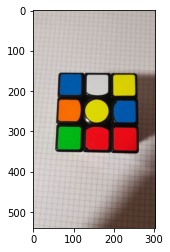

1 ['B', 'D', 'U', 'R', 'U', 'B', 'F', 'L', 'L']


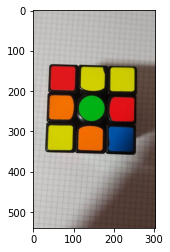

2 ['L', 'U', 'U', 'R', 'F', 'L', 'U', 'R', 'B']


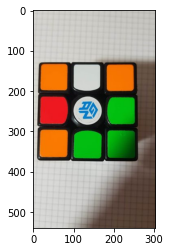

3 ['R', 'D', 'R', 'L', 'D', 'F', 'R', 'F', 'F']


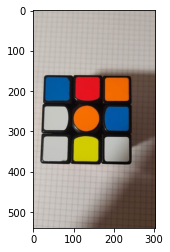

4 ['B', 'L', 'R', 'D', 'R', 'B', 'D', 'U', 'D']


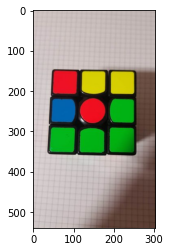

5 ['L', 'U', 'U', 'B', 'L', 'F', 'F', 'F', 'F']


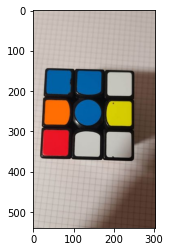

6 ['B', 'B', 'D', 'R', 'B', 'U', 'L', 'D', 'D']
The cube's state is:  BDURUBFLLBLRDRBDUDLUURFLURBRDRLDFRFFLUUBLFFFFBBDRBULDD
The solution for this state:  R F' L' B2 U2 L B' D' F' B L U2 F2 U D' F2 D R2 L2 U' F2


In [108]:
cube_state = [[0]]*6 #the order of colors on the whole cube

for i in range(1,7):
    path = f"case1/cube{i}.jpg"
    
    orig_img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.show()

    cut_cubies, meanarea = clustering(img)
    meanside = int(np.sqrt(meanarea))

    cubie_coords_arr, cubies = cubie_colors(cut_cubies,meanarea,meanside)

    curr_face = cubie_locator(cubie_coords_arr,cubies, meanside)

    cube_state[color_names.index(curr_face[4])] = curr_face

    print(i,curr_face)



#print("cube_state", flatlist(cube_state))

#print(color_names.index(cubie_locator(cubie_coords_arr,cubies, meanside)[4]))

cube_input = ''

for i in range (len(cube_state)):
    for j in range(9):
        cube_input = cube_input + cube_state[i][j]

print("The cube's state is: ",cube_input)

print("The solution for this state: ", kociemba.solve(cube_input))




In [109]:
cube_input = ''

for i in range (len(cube_state)):
    for j in range(9):
        cube_input = cube_input + cube_state[i][j]

print("The cube's state is: ",cube_input)

print("The solution for this state: ", kociemba.solve(cube_input))

The cube's state is:  BDURUBFLLBLRDRBDUDLUURFLURBRDRLDFRFFLUUBLFFFFBBDRBULDD
The solution for this state:  R F' L' B2 U2 L B' D' F' B L U2 F2 U D' F2 D R2 L2 U' F2
